In [ ]:
import os
import json
import hashlib
from pathlib import Path

try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

try:
    from scipy.stats import ks_2samp
except ImportError as e:
    raise ImportError("Q2 requires SciPy. Install with: pip install scipy") from e


repo_root = Path.cwd()

gan_scripts_dir = Path(os.environ.get("GAN_SCRIPTS_DIR", str(repo_root))).resolve()

training_script_path = gan_scripts_dir / "LOB_GAN_training.py"
testing_script_path  = gan_scripts_dir / "LOB_GAN_testing.py"

# .env
if "LOB_GAN_DATA_DIR" not in os.environ:
    raise EnvironmentError(
        "Missing LOB_GAN_DATA_DIR. Create a .env with:\n"
        "LOB_GAN_DATA_DIR=YOUR_PATH_TO_assignment4_datafiles"
    )
stock_data_dir = Path(os.environ["LOB_GAN_DATA_DIR"]).resolve()

# Outputs/caches
q1_output_root = (repo_root / "q1_notebook_outputs").resolve()
q2_output_root = (repo_root / "q2_notebook_outputs").resolve()
cache_root     = (repo_root / "cache").resolve()

q1_output_root.mkdir(parents=True, exist_ok=True)
q2_output_root.mkdir(parents=True, exist_ok=True)
cache_root.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Repo root:", repo_root)
print("Scripts dir:", gan_scripts_dir)
print("Data dir:", stock_data_dir)
print("Device:", device)





Repo root: c:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4
Scripts dir: C:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4
Data dir: C:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4\assignment4_datafiles
Device: cpu


In [ ]:
def _stable_json_hash(payload: dict) -> str:
    encoded = json.dumps(payload, sort_keys=True, separators=(",", ":")).encode("utf-8")
    return hashlib.sha256(encoded).hexdigest()[:16]


def _write_json(path: Path, payload: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(payload, indent=2, sort_keys=True), encoding="utf-8")


def _read_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding="utf-8"))


def _config_matches(cache_config_path: Path, expected_config: dict) -> bool:
    if not cache_config_path.exists():
        return False
    saved = _read_json(cache_config_path)
    return saved.get("config_hash") == expected_config.get("config_hash")


def _ensure_script_env_ready(script_path: Path, required_env_markers: list[str]) -> None:
    """
    Ensures the provided scripts were minimally adapted to read env vars.
    """
    text = script_path.read_text(encoding="utf-8", errors="ignore")
    missing = [m for m in required_env_markers if m not in text]
    if missing:
        raise RuntimeError(
            f"{script_path.name} does not appear to support env configuration.\n"
            f"Missing markers: {missing}\n\n"
            "Fix: inside if __name__=='__main__': read stockDataDir/stock/LRs from os.environ.\n"
            "If you already did this, ensure the literal strings appear in the file."
        )


In [ ]:
import subprocess
import sys

def run_python_script(script_path, working_dir, env_overrides):
    env = os.environ.copy()
    env.update(env_overrides)
    env.setdefault("MPLBACKEND", "Agg")

    completed = subprocess.run(
        [sys.executable, str(script_path)],
        cwd=str(working_dir),
        env=env,
        capture_output=True,
        text=True,
    )

    if completed.returncode != 0:
        print("\n SUBPROCESS STDOUT\n", completed.stdout)
        print("\n SUBPROCESS STDERR\n", completed.stderr)
        raise RuntimeError(
            f"Script failed: {script_path.name} (exit={completed.returncode}). "
            f"See stdout/stderr above."
        )

    
    if completed.stdout.strip():
        print(completed.stdout)



def q1_artifacts_present(ticker_dir: Path, ticker: str) -> bool:
    """Check for the minimal set of outputs in cache"""
    needed = [
        ticker_dir / f"{ticker}_generator1.pth",
        ticker_dir / f"{ticker}_discriminator1.pth",
        ticker_dir / f"{ticker}_train_g_d.csv",
        ticker_dir / f"{ticker}_eval_g_d.csv",
    ]
    return all(p.exists() for p in needed)


def q1_plot_present(ticker_dir: Path, ticker: str) -> bool:
    """Loss plot"""
    return (ticker_dir / f"{ticker}_q1_loss_curves.png").exists()


def q1_test_marker_present(ticker_dir: Path, ticker: str) -> bool:
    """Marker file indicating the testing script ran successfully."""
    return (ticker_dir / f"{ticker}__testing_ok.marker").exists()


def q1_make_run_config(
    ticker: str,
    train_months: list[str],
    lr_g: float,
    lr_d: float,
    batch_size: int,
    epochs: int,
    seed: int,
) -> dict:
    cfg = {
        "ticker": ticker,
        "train_months": train_months,
        "lr_g": lr_g,
        "lr_d": lr_d,
        "batch_size": batch_size,
        "epochs": epochs,
        "seed": seed,
        "data_dir": str(stock_data_dir),
        "training_script": str(training_script_path),
        "testing_script": str(testing_script_path),
    }
    cfg["config_hash"] = _stable_json_hash(cfg)
    return cfg


def q1_plot_losses_from_csv(ticker_dir: Path, ticker: str, smooth_window: int = 25) -> None:
    """
    Plot training/validation loss curves from the CSVs written by the training script.
    """
    train_csv = ticker_dir / f"{ticker}_train_g_d.csv"
    eval_csv  = ticker_dir / f"{ticker}_eval_g_d.csv"

    train_df = pd.read_csv(train_csv, index_col=0)
    eval_df  = pd.read_csv(eval_csv, index_col=0)

    def _row(df: pd.DataFrame, name: str) -> np.ndarray:
        s = df.loc[name].dropna().to_numpy(dtype=float)
        if smooth_window > 1:
            s = pd.Series(s).rolling(smooth_window, min_periods=1).mean().to_numpy()
        return s

    train_g = _row(train_df, "train_g")
    train_d = _row(train_df, "train_d")
    eval_g  = _row(eval_df, "eval_g")
    eval_d  = _row(eval_df, "eval_d")

    fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=False)

    axes[0].plot(train_g, label="G train")
    axes[0].plot(eval_g,  label="G validation")
    axes[0].set_title(f"{ticker} — Generator loss (smoothed window={smooth_window})")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.25)
    axes[0].legend()

    axes[1].plot(train_d, label="D train")
    axes[1].plot(eval_d,  label="D validation")
    axes[1].set_title(f"{ticker} — Discriminator loss")
    axes[1].set_xlabel("Update step (mini-batch)")
    axes[1].set_ylabel("Loss")
    axes[1].grid(True, alpha=0.25)
    axes[1].legend()

    plt.tight_layout()
    out_path = ticker_dir / f"{ticker}_q1_loss_curves.png"
    plt.savefig(out_path, dpi=160)
    plt.show()
    print(f" Saved: {out_path}")


[Q1] 0050: cached training found (skipping training).
[Q1] 0050: cached loss plot found (skipping plot).
[Q1] 0050: running testing (smoke check).
Raw data loading and processing 0050
Data 1 for 0050 loaded.
Data 2 for 0050 loaded.
Data 3 for 0050 loaded.
Minutely data generated.
Model loaded.
Not enough variance in discriminated returns for KDE; skipping that curve.
Skipping real return KDE due to error: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Figure(800x400)

[Q1] 0056: training not cached or config changed (running training).
Raw data loading and processing 0056
Data 1 for 0056 loaded.
Data 2 for 0056 loaded.
Data 3 for 0056 loaded.
Minutely data generated.
[Epoch 1/200][Batch 1/1][D train loss: 0.250004][G train loss: 1.113681]
[Epoch 1/200][Batch 1/1][D eval loss: 0.250019][G eval loss: 0.984677]
[Epoch 2/200][Batch 1/1][D train loss: 0.250016][G train loss: 1.087153]
[Epoch 2/200][Batch 1/1][D eval loss: 0.249996][G eval loss

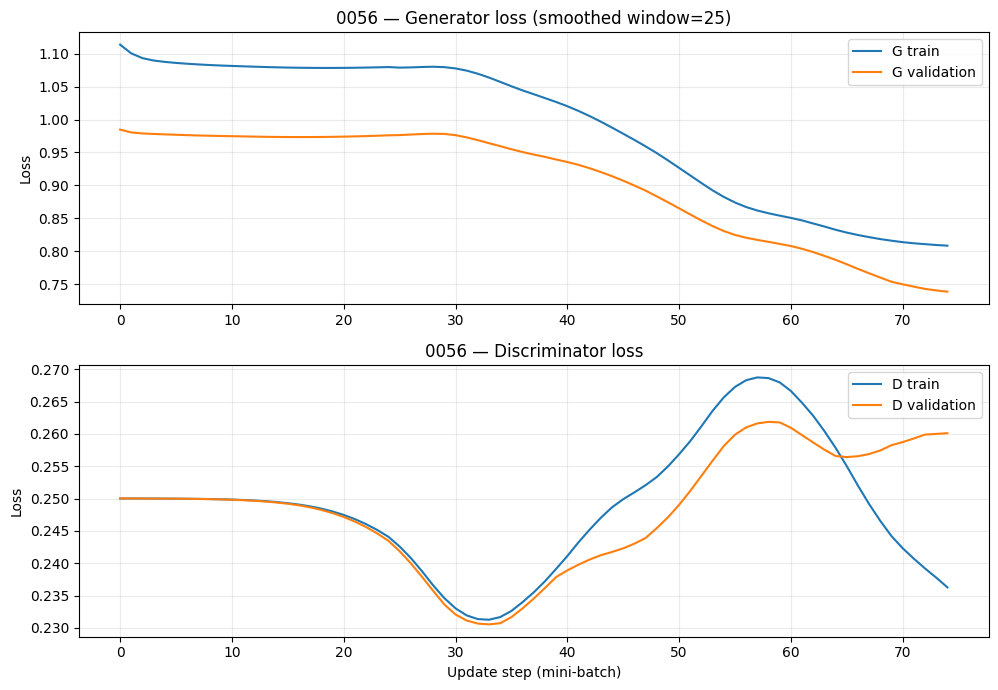

[Q1] Saved: C:\Users\kylep\Desktop\Homework Autumn 2025\Market Micro\hw_4\q1_notebook_outputs\0056\0056_q1_loss_curves.png
[Q1] 0056: running testing (smoke check).
Raw data loading and processing 0056
Data 1 for 0056 loaded.
Data 2 for 0056 loaded.
Data 3 for 0056 loaded.
Minutely data generated.
Model loaded.
Skipping real return KDE due to error: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Figure(800x400)

[Q1] 2330: training not cached or config changed (running training).


In [ ]:
q1_tickers = ["0050", "0056", "2330"]
q1_train_months = ["202310", "202311", "202312"]

# tuning
q1_hyperparams = {
    "0050": {"lr_g": 0.00375, "lr_d": 0.00100},
    "0056": {"lr_g": 0.00375, "lr_d": 0.00100},
    "2330": {"lr_g": 0.00300, "lr_d": 0.00100},
}
q1_batch_size = int(os.environ.get("LOB_GAN_BATCH_SIZE", "50"))
q1_epochs     = int(os.environ.get("LOB_GAN_EPOCHS", "200"))
q1_seed       = int(os.environ.get("LOB_GAN_SEED", "307"))

# Ensuring scripts are env-ready
required_markers = ["LOB_GAN_DATA_DIR", "LOB_GAN_STOCK"]
_ensure_script_env_ready(training_script_path, required_markers)
_ensure_script_env_ready(testing_script_path, required_markers)

for ticker in q1_tickers:
    ticker_dir = q1_output_root / ticker
    ticker_dir.mkdir(parents=True, exist_ok=True)

    lr_g = float(q1_hyperparams[ticker]["lr_g"])
    lr_d = float(q1_hyperparams[ticker]["lr_d"])

    run_cfg = q1_make_run_config(
        ticker=ticker,
        train_months=q1_train_months,
        lr_g=lr_g,
        lr_d=lr_d,
        batch_size=q1_batch_size,
        epochs=q1_epochs,
        seed=q1_seed,
    )
    cfg_path = ticker_dir / "q1_run_config.json"

    if q1_artifacts_present(ticker_dir, ticker) and _config_matches(cfg_path, run_cfg):
        print(f"{ticker}: cached training found skipping training")
    else:
        print(f"{ticker}: training not cached or config changed running training")

        env = {
            "LOB_GAN_DATA_DIR": str(stock_data_dir),
            "LOB_GAN_STOCK": ticker,
            "LOB_GAN_SEED": str(q1_seed),

            "KMP_DUPLICATE_LIB_OK": "TRUE",

            "OMP_NUM_THREADS": "1",
            "MKL_NUM_THREADS": "1",

            "LOB_GAN_SKIP_PLOTS": "1",
        }

        run_python_script(training_script_path, ticker_dir, env)
        _write_json(cfg_path, run_cfg)

    if q1_plot_present(ticker_dir, ticker) and _config_matches(cfg_path, run_cfg):
        print(f"{ticker}: cached loss plot found skipping plot.")
    else:
        q1_plot_losses_from_csv(ticker_dir, ticker, smooth_window=25)

    # testing both files
    if q1_test_marker_present(ticker_dir, ticker) and _config_matches(cfg_path, run_cfg):
        print(f"{ticker}: cached testing run found skipping testing")
    else:
        print(f"{ticker}: running testing ")

        env = {
            "LOB_GAN_DATA_DIR": str(stock_data_dir),
            "LOB_GAN_STOCK": ticker,
            "LOB_GAN_SEED": str(q1_seed),
        }
        run_python_script(testing_script_path, ticker_dir, env)

        (ticker_dir / f"{ticker}__testing_ok.marker").write_text("ok", encoding="utf-8")

print("\n[Q1] Done.")


In [ ]:
if str(gan_scripts_dir) not in sys.path:
    sys.path.insert(0, str(gan_scripts_dir))

import importlib

lob_ref = importlib.import_module("LOB_GAN_training")
prepare_minutely_data = lob_ref.prepareMinutelyData


In [ ]:
LOB_COLS = [
    "date","time","lastPx","size","volume",
    "SP1","BP1","SV1","BV1",
    "SP2","BP2","SV2","BV2",
    "SP3","BP3","SV3","BV3",
    "SP4","BP4","SV4","BV4",
    "SP5","BP5","SV5","BV5",
]


def q2_cache_paths(ticker: str, months: list[str], threshold: float, version: str = "v1") -> dict:
    """
    Centralized file paths for Q2 caches.
    Bump 'version' if you change feature definitions.
    """
    tag = f"{version}__{ticker}__{'-'.join(months)}__thr{threshold:.3f}"
    base = cache_root / "q2" / ticker
    base.mkdir(parents=True, exist_ok=True)
    return {
        "cfg": base / f"q2_config__{tag}.json",
        "minutely_pkl": base / f"minutely__{tag}.pkl",
        "X_npz": base / f"ganX__{tag}.npz",
        "day_scores_csv": base / f"day_scores__{tag}.csv",
        "features_pkl": base / f"features__{tag}.pkl",
        "results_csv": base / f"results__{tag}.csv",
    }


def q2_make_run_config(ticker: str, months: list[str], threshold: float) -> dict:
    cfg = {
        "ticker": ticker,
        "months": months,
        "threshold": float(threshold),
        "data_dir": str(stock_data_dir),
        "discriminator_path": str((q1_output_root / ticker / f"{ticker}_discriminator1.pth").resolve()),
        "feature_version": "v1",
    }
    cfg["config_hash"] = _stable_json_hash(cfg)
    return cfg


def q2_load_raw_months(ticker: str, months: list[str]) -> pd.DataFrame:
    parts = []
    for m in months:
        fp = stock_data_dir / f"{ticker}_md_{m}_{m}.csv.gz"
        if not fp.exists():
            print(f"[WARN] Missing file: {fp.name} (skipping)")
            continue
        parts.append(pd.read_csv(fp, compression="gzip", usecols=LOB_COLS))
        print(f"Loaded {fp.name}")
    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()


In [ ]:
def q2_load_or_build_minutely(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["minutely_pkl"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_pickle(paths["minutely_pkl"])

    raw_df = q2_load_raw_months(ticker, months)
    if raw_df.empty:
        raise FileNotFoundError(f"No raw test data loaded for {ticker} months={months}")

    trading_days_present = sorted(raw_df["date"].astype(str).unique().tolist())
    minutely_df = prepare_minutely_data(raw_df, trading_days_present)
    if minutely_df is None or minutely_df.empty:
        raise ValueError(f"prepareMinutelyData produced empty minutely df for {ticker}")

    minutely_df.to_pickle(paths["minutely_pkl"])
    _write_json(paths["cfg"], cfg)
    return minutely_df


def q2_build_gan_X_and_dates(minutely_df: pd.DataFrame) -> tuple[np.ndarray, list[str]]:
    """Same shaping/normalization as provided scripts: daily 265-min sequences -> X (N,265,20)."""
    daily_arrays = []
    daily_dates = []

    for date_key, day_df in minutely_df.groupby("date", sort=True):
        if day_df.shape[0] == 265:
            daily_arrays.append(day_df.values)
            daily_dates.append(str(date_key))

    projdata = np.array(daily_arrays)
    if projdata.size == 0:
        raise ValueError("No full 265-minute days found in testing data.")

    X = projdata[:, :, 5:].astype(float)
    X[:, :, -10:] = np.log(1.0 + X[:, :, -10:])

    mu = X.mean(axis=1)
    sig = X.std(axis=1)
    X = np.transpose((np.transpose(X, (1, 0, 2)) - mu) / (2.0 * sig), (1, 0, 2))
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X, daily_dates


def q2_load_or_build_ganX(ticker: str, months: list[str], threshold: float) -> tuple[np.ndarray, list[str]]:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["X_npz"].exists() and _config_matches(paths["cfg"], cfg):
        blob = np.load(paths["X_npz"], allow_pickle=True)
        return blob["X"], blob["daily_dates"].tolist()

    minutely_df = q2_load_or_build_minutely(ticker, months, threshold)
    X, dates = q2_build_gan_X_and_dates(minutely_df)

    np.savez_compressed(paths["X_npz"], X=X, daily_dates=np.array(dates, dtype=object))
    _write_json(paths["cfg"], cfg)
    return X, dates


In [ ]:
def q2_load_discriminator(ticker: str) -> torch.nn.Module:
    model_path = q1_output_root / ticker / f"{ticker}_discriminator1.pth"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing discriminator model for {ticker}: {model_path} (run Q1 first)")

    # Handle different torch versions
    try:
        model = torch.load(model_path, map_location=device, weights_only=False)
    except TypeError:
        model = torch.load(model_path, map_location=device)

    model.eval()
    return model


@torch.no_grad()
def q2_score_days(discriminator: torch.nn.Module, X: np.ndarray, batch_size: int = 64) -> np.ndarray:
    discriminator = discriminator.to(device)
    scores = []
    n = X.shape[0]
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch = torch.tensor(X[start:end], dtype=torch.float32, device=device)
        out = discriminator(batch).detach().cpu().numpy().reshape(-1)
        scores.append(out)
    return np.concatenate(scores, axis=0)


def q2_load_or_build_day_scores(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["day_scores_csv"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_csv(paths["day_scores_csv"])

    X, dates = q2_load_or_build_ganX(ticker, months, threshold)
    disc = q2_load_discriminator(ticker)

    scores = q2_score_days(disc, X, batch_size=64)
    out = pd.DataFrame({
        "date": dates,
        "discriminator_score": scores,
        "is_abnormal": scores <= threshold,
    })

    out.to_csv(paths["day_scores_csv"], index=False)
    _write_json(paths["cfg"], cfg)
    return out


In [ ]:
def q2_compute_features(minutely_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute variables required by Q2:

    - trade_price_return: pct-change of lastPx within day
    - midquote_return: pct-change of (BP1+SP1)/2 within day
    - trade_size: size
    - spread: SP1 - BP1
    - spread_diff_1: first difference of spread within day
    - pressure_1: (BV1 - SV1)/(BV1 + SV1)
    - pressure_5: sum(BVi-SVi)/sum(BVi+SVi), i=1..5
    """
    df = minutely_df.copy()
    df = df.sort_index()

    df["date_str"] = df["date"].astype(str)

    # Mid quote + spread
    df["midquote"] = (df["BP1"].astype(float) + df["SP1"].astype(float)) / 2.0
    df["spread"] = df["SP1"].astype(float) - df["BP1"].astype(float)

    # Returns/diffs within day
    df["trade_price_return"] = df.groupby("date_str")["lastPx"].astype(float).pct_change()
    df["midquote_return"] = df.groupby("date_str")["midquote"].pct_change()
    df["spread_diff_1"] = df.groupby("date_str")["spread"].diff()

    df["trade_size"] = df["size"].astype(float)

    # Pressure 1-level
    bv1 = df["BV1"].astype(float)
    sv1 = df["SV1"].astype(float)
    denom1 = bv1 + sv1
    df["pressure_1"] = np.where(denom1 != 0, (bv1 - sv1) / denom1, np.nan)

    # Pressure 5-level
    bv_cols = [f"BV{i}" for i in range(1, 6)]
    sv_cols = [f"SV{i}" for i in range(1, 6)]
    bv_sum = df[bv_cols].astype(float).sum(axis=1)
    sv_sum = df[sv_cols].astype(float).sum(axis=1)
    denom5 = bv_sum + sv_sum
    df["pressure_5"] = np.where(denom5 != 0, (bv_sum - sv_sum) / denom5, np.nan)

    feature_cols = [
        "date_str", "time",
        "trade_price_return", "midquote_return",
        "trade_size",
        "spread", "spread_diff_1",
        "pressure_1", "pressure_5",
    ]
    out = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    return out


def q2_load_or_build_features(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["features_pkl"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_pickle(paths["features_pkl"])

    minutely_df = q2_load_or_build_minutely(ticker, months, threshold)
    features = q2_compute_features(minutely_df)

    features.to_pickle(paths["features_pkl"])
    _write_json(paths["cfg"], cfg)
    return features


In [ ]:
def q2_moments(series: pd.Series) -> dict:
    """
    mean/variance/skew/kurtosis
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return {"n": 0, "mean": np.nan, "var": np.nan, "skew": np.nan, "kurt_excess": np.nan}
    return {
        "n": int(s.shape[0]),
        "mean": float(s.mean()),
        "var": float(s.var(ddof=1)),
        "skew": float(s.skew()),
        "kurt_excess": float(s.kurt()),
    }


def q2_ks(a: pd.Series, b: pd.Series) -> dict:
    a = pd.to_numeric(a, errors="coerce").dropna().to_numpy(dtype=float)
    b = pd.to_numeric(b, errors="coerce").dropna().to_numpy(dtype=float)
    if a.size < 2 or b.size < 2:
        return {"ks_stat": np.nan, "ks_pvalue": np.nan}
    res = ks_2samp(a, b, alternative="two-sided", mode="auto")
    return {"ks_stat": float(res.statistic), "ks_pvalue": float(res.pvalue)}


def q2_load_or_build_results(ticker: str, months: list[str], threshold: float) -> pd.DataFrame:
    paths = q2_cache_paths(ticker, months, threshold)
    cfg = q2_make_run_config(ticker, months, threshold)

    if paths["results_csv"].exists() and _config_matches(paths["cfg"], cfg):
        return pd.read_csv(paths["results_csv"])

    day_scores = q2_load_or_build_day_scores(ticker, months, threshold)
    abnormal_days = set(day_scores.loc[day_scores["is_abnormal"], "date"].astype(str))

    features = q2_load_or_build_features(ticker, months, threshold)
    features["is_abnormal_day"] = features["date_str"].isin(abnormal_days)

    variables = {
        "trade_price_returns": "trade_price_return",
        "midquote_returns": "midquote_return",
        "trade_size": "trade_size",
        "bid_ask_spread": "spread",
        "spread_first_diff": "spread_diff_1",
        "pressure_level_1": "pressure_1",
        "pressure_level_5": "pressure_5",
    }

    rows = []
    for pretty_name, col in variables.items():
        ab = features.loc[features["is_abnormal_day"], col]
        no = features.loc[~features["is_abnormal_day"], col]

        # if pretty_name == "trade_size":
        #     ab = ab[ab > 0]
        #     no = no[no > 0]

        ab_m = q2_moments(ab)
        no_m = q2_moments(no)
        ks = q2_ks(ab, no)

        rows.append({
            "ticker": ticker,
            "variable": pretty_name,
            **{f"abnormal_{k}": v for k, v in ab_m.items()},
            **{f"normal_{k}": v for k, v in no_m.items()},
            **ks,
        })

    result_df = pd.DataFrame(rows)
    result_df.to_csv(paths["results_csv"], index=False)
    _write_json(paths["cfg"], cfg)
    return result_df


In [ ]:
q2_tickers = ["0050", "0056", "2330"]
q2_months = ["202401", "202402", "202403"]
q2_threshold = 0.5

all_results = []
for t in q2_tickers:
    print(f"\n[Q2] {t} ...")
    df = q2_load_or_build_results(t, q2_months, q2_threshold)
    all_results.append(df)

q2_results_all = pd.concat(all_results, ignore_index=True)
q2_results_all


In [ ]:
combined_out = q2_output_root / "q2_all_tickers_summary.csv"
q2_results_all.to_csv(combined_out, index=False)
print("Saved:", combined_out)
